# Pre-procesamiento

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../src')

from matplotlib import pyplot as plt
import seaborn  as sns

import numpy  as np
import pandas as pd
import torch

import logging
import random

import data  as dt
import model as ml
import util  as ut
import pytorch_common.util as pu

from sklearn.model_selection import train_test_split

## Setup

Se configura el default logger para que la consola sea el output y loguee mensajes a partir del nivel INFO.

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

Chequeamos si se detecta la GPU:

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.__version__

'1.12.1+cu116'

Por defecto usamos GPU. De no existir este hardware, el fallback es CPU:

In [6]:
pu.set_device_name('gpu')

logging.info(pu.get_device())

2022-09-23 17:37:37,000 - INFO - cuda:0


In [7]:
torch.cuda.get_arch_list()

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']

Fijamos la semilla:

In [8]:
def set_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)

In [9]:
set_seed(42)

Parametros de la notebook:

In [10]:
DATASET_PATH = '../../datasets/fashion-outfits'

se excluyen ramas con menos de 10 productos:

In [11]:
MIN_PRODUCTS_BY_BRANCH = 500
MAX_PRODUCTS_BY_BRANCH = 1000

Se excluyen productos con un title de mas de 20 tokens para bajar los tiempos den entrenamiento:

In [12]:
MAX_TOKENS = 100

Tamaño de los conjuntos de entrenamiento valizacion y test:

In [13]:
TRAIN_SIZE = 0.9
VAL_SIZE   = 0.5 # Cantidad a tomar luego de quitar el conjunto de train. El restante pertene de al conjunto de test.

### Funciones helper

In [14]:
def plot_columns(df, x_col, y_col, title):
    plt.figure(figsize=(8,5))
    ax = sns.barplot(x=x_col, y=y_col, data=df,  orient = 'h', order = df[y_col].values)
    ax.set(xlabel=x_col)
    ax.set(ylabel=y_col)
    ax.set(yticklabels=[])
    ax.set_title(title)
    plt.show()

    
def plot_branch_count(df):
    plot_columns(
        df, 
        y_col = 'branch', 
        x_col = 'count', 
        title = 'Cantidad de productos por rama del arbol de categorias'
    )
    
    
def plot_tokens_count(df):
    df['description'] \
        .apply(lambda x: len(x.split(' '))) \
        .value_counts() \
        .plot(
            kind   = 'bar', 
            rot    = 45,
            xlabel = 'Cant. Tokens',
            ylabel = 'Cant. Productos',
            title  = 'Cantidad de tokens en la descripción de un producto' 
        )

## Preparar dataset

**Step 1**: Cargamos eld ataset original.

In [15]:
dataset = pd.read_parquet(f'{DATASET_PATH}/products.parquet')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398670 entries, 0 to 398669
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   product_id                 398670 non-null  int32 
 1   product_family             398670 non-null  object
 2   product_category           398670 non-null  object
 3   product_sub_category       398670 non-null  object
 4   product_gender             398670 non-null  object
 5   product_main_colour        398670 non-null  object
 6   product_second_color       398658 non-null  object
 7   product_brand              398670 non-null  object
 8   product_materials          398504 non-null  object
 9   product_short_description  398670 non-null  object
 10  product_attributes         234250 non-null  object
 11  product_image_path         398670 non-null  object
 12  product_highlights         383316 non-null  object
dtypes: int32(1), object(12)
memory usage: 38.0+ 

In [16]:
dataset.head()

,product_id,product_family,product_category,product_sub_category,product_gender,product_main_colour,product_second_color,product_brand,product_materials,product_short_description,product_attributes,product_image_path,product_highlights
0,17073270,Clothing,Knitwear,Cardi-Coats,UNISEX,BLACK,WHITE,STELLA MCCARTNEY,[Cotton],x The Beatles intarsia-knit coat,"[{""attribute_name"":""Knit Neckline"",""attribute_...",17/07/32/70/17073270.jpg,"[black/white, organic cotton, mix print, intar..."
1,17674562,Clothing,Knitwear,Cardi-Coats,UNISEX,PURPLE,N/D,extreme cashmere,"[Spandex/Elastane, Nylon, Cashmere]",cashmere-blend long belted cardigan,"[{""attribute_name"":""Knit Neckline"",""attribute_...",17/67/45/62/17674562.jpg,"[plum purple, cashmere blend, wrap design, sle..."
2,17678603,Clothing,Knitwear,Cardi-Coats,UNISEX,BLUE,N/D,extreme cashmere,"[Spandex/Elastane, Cashmere, Nylon]",cashmere-blend long belted cardigan,"[{""attribute_name"":""Knit Neckline"",""attribute_...",17/67/86/03/17678603.jpg,"[blue, cashmere blend, wrap design, sleeveless..."
3,17179699,Clothing,Knitwear,Cardi-Coats,UNISEX,PINK,N/D,extreme cashmere,"[Nylon, Spandex/Elastane, Cashmere]",long cashmere cardigan,"[{""attribute_name"":""Knit Neckline"",""attribute_...",17/17/96/99/17179699.jpg,"[light pink, stretch-cashmere blend, fine knit..."
4,15907453,Clothing,Sweaters & Knitwear,Cardigans,MEN,NEUTRALS,N/D,THE ELDER STATESMAN,[Cashmere],tie-dye print cashmere cardigan,None,15/90/74/53/15907453.jpg,"[multicolour, cashmere, tie-dye print, knitted..."


**Step 2**: normalizamos nombres de colimnas y las variable categoricas. Tambien borramos columnnas y folas con nulos.

In [17]:
def norm_text(df, columns):
    for col in columns:
        df[col] = df[col].apply(lambda x: x.lower().strip())

TEXT_COLS = ['product_family', 'product_category', 'product_sub_category', 'product_brand', 'product_gender']
        
norm_text(dataset, TEXT_COLS)


dataset = dataset.rename(columns={
    'product_id'               : 'id',
    'product_gender'           : 'gender',    
    'product_short_description': 'description', 
    'product_highlights'       : 'highlights',
    'product_image_path'       : 'image',
    'product_materials'        : 'materials',
    'product_family'           : 'family',
    'product_category'         : 'category',
    'product_sub_category'     : 'sub_category', 
    'product_brand'            : 'brand',
    'product_main_colour'      : 'main_colour', 
    'product_second_color'     : 'second_color',
    'product_image_path'       : 'image_uri'
})


products = dataset[['id', 'family', 'category', 'sub_category', 'description', 'highlights', 'brand', 'gender', 'materials', 'image_uri']]
products['branch'] = products['family'] + '~' + products['category'] + '~' + products['sub_category']

products.dropna(how='all', axis=1).dropna(axis=0)
products.head()

,id,family,category,sub_category,description,highlights,brand,gender,materials,image_uri,branch
0,17073270,clothing,knitwear,cardi-coats,x The Beatles intarsia-knit coat,"[black/white, organic cotton, mix print, intar...",stella mccartney,unisex,[Cotton],17/07/32/70/17073270.jpg,clothing~knitwear~cardi-coats
1,17674562,clothing,knitwear,cardi-coats,cashmere-blend long belted cardigan,"[plum purple, cashmere blend, wrap design, sle...",extreme cashmere,unisex,"[Spandex/Elastane, Nylon, Cashmere]",17/67/45/62/17674562.jpg,clothing~knitwear~cardi-coats
2,17678603,clothing,knitwear,cardi-coats,cashmere-blend long belted cardigan,"[blue, cashmere blend, wrap design, sleeveless...",extreme cashmere,unisex,"[Spandex/Elastane, Cashmere, Nylon]",17/67/86/03/17678603.jpg,clothing~knitwear~cardi-coats
3,17179699,clothing,knitwear,cardi-coats,long cashmere cardigan,"[light pink, stretch-cashmere blend, fine knit...",extreme cashmere,unisex,"[Nylon, Spandex/Elastane, Cashmere]",17/17/96/99/17179699.jpg,clothing~knitwear~cardi-coats
4,15907453,clothing,sweaters & knitwear,cardigans,tie-dye print cashmere cardigan,"[multicolour, cashmere, tie-dye print, knitted...",the elder statesman,men,[Cashmere],15/90/74/53/15907453.jpg,clothing~sweaters & knitwear~cardigans


**Step 3**:  Filtramos productos con mas de MAX_TOKENS tokens en la descripcion, para disminiur el tiempo de entrenamiento.

In [18]:
products['desc_tokens']  = products['description'].apply(lambda x: x.split(' '))
products['tokens_count'] = products['desc_tokens'].apply(len)

In [19]:
products['tokens_count'].min(), products['tokens_count'].max()

(1, 40)

In [20]:
# plot_columns(
#    products,
#    x_col = 'tokens_count',
#    y_col = 'description',
#    title = 'Product description: Cantidad de tokens'
#)

In [21]:
filtered_products = products[products['tokens_count'] < MAX_TOKENS]

In [22]:
filtered_products['tokens_count'].min(), filtered_products['tokens_count'].max()

(1, 40)

In [23]:
# plot_columns(
#    filtered_products,
#    x_col = 'tokens_count',
#    y_col = 'description',
#    title = 'Product description: Cantidad de tokens'from sklearn.utils import resample
#)

**Step 4**: seleccionamos las columnas y tipos de datos finales.

In [24]:
filtered_products = filtered_products[
    ['id', 'family', 'category', 'sub_category', 'description', 'highlights', 'brand', 'gender', 'materials', 'branch',  'tokens_count', 'image_uri']
]

filtered_products.dropna(how='all', axis=1).dropna(axis=0)

filtered_products = filtered_products.astype({    
    'id': int,
    'family': str,
    'category': str,
    'sub_category': str,
    'brand': str,
    'gender': str,
    'branch': str,
    'description': str
})

filtered_products.head()

,id,family,category,sub_category,description,highlights,brand,gender,materials,branch,tokens_count,image_uri
0,17073270,clothing,knitwear,cardi-coats,x The Beatles intarsia-knit coat,"[black/white, organic cotton, mix print, intar...",stella mccartney,unisex,[Cotton],clothing~knitwear~cardi-coats,5,17/07/32/70/17073270.jpg
1,17674562,clothing,knitwear,cardi-coats,cashmere-blend long belted cardigan,"[plum purple, cashmere blend, wrap design, sle...",extreme cashmere,unisex,"[Spandex/Elastane, Nylon, Cashmere]",clothing~knitwear~cardi-coats,4,17/67/45/62/17674562.jpg
2,17678603,clothing,knitwear,cardi-coats,cashmere-blend long belted cardigan,"[blue, cashmere blend, wrap design, sleeveless...",extreme cashmere,unisex,"[Spandex/Elastane, Cashmere, Nylon]",clothing~knitwear~cardi-coats,4,17/67/86/03/17678603.jpg
3,17179699,clothing,knitwear,cardi-coats,long cashmere cardigan,"[light pink, stretch-cashmere blend, fine knit...",extreme cashmere,unisex,"[Nylon, Spandex/Elastane, Cashmere]",clothing~knitwear~cardi-coats,3,17/17/96/99/17179699.jpg
4,15907453,clothing,sweaters & knitwear,cardigans,tie-dye print cashmere cardigan,"[multicolour, cashmere, tie-dye print, knitted...",the elder statesman,men,[Cashmere],clothing~sweaters & knitwear~cardigans,4,15/90/74/53/15907453.jpg


In [25]:
filtered_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398670 entries, 0 to 398669
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            398670 non-null  int64 
 1   family        398670 non-null  object
 2   category      398670 non-null  object
 3   sub_category  398670 non-null  object
 4   description   398670 non-null  object
 5   highlights    383316 non-null  object
 6   brand         398670 non-null  object
 7   gender        398670 non-null  object
 8   materials     398504 non-null  object
 9   branch        398670 non-null  object
 10  tokens_count  398670 non-null  int64 
 11  image_uri     398670 non-null  object
dtypes: int64(2), object(10)
memory usage: 39.5+ MB


**Step 5**: Juntamos las categorias que conjunde el modelo y ademas son miy similares entre si.

In [26]:
filtered_products['branch'].unique().shape

(338,)

In [27]:
similar_categories = {
  'clothing~coats~oversized coats'       : 'clothing~coats~single breasted coats',
  'clothing~jackets~cropped jackets'     : 'clothing~jackets~fitted jackets',
  'clothing~jackets~lightweight jackets' : 'clothing~jackets~sport jackets & windbreakers',
  'clothing~trousers~skinny trousers'    : 'clothing~trousers~slim-fit trousers'
}
filtered_products['branch'] = filtered_products['branch'].apply(lambda x: similar_categories[x] if x in similar_categories else x)

In [28]:
filtered_products['branch'].unique().shape

(334,)

**Step 6**: Dowsampling de clases mayoritarias. Data que tenemo un gran nivel de desbalance de las clase, se realizara un downsampling, es decir tomar un maximo de ejemplo para las cases mayoritarias. De esta foram se intenta aumentar el balance de clases en el dataset.

In [29]:
products_by_branch = ut.group_by_count(filtered_products, 'branch', 'id')
products_by_branch.head()

,branch,count
200,clothing~t-shirts & vests~t-shirts,25484
133,clothing~dresses~day dresses,21663
214,clothing~tops~t-shirts & jerseys,16717
82,bags~tote bags~n/d,14910
166,clothing~shirts~n/d,14602


<Figure size 800x500 with 1 Axes>

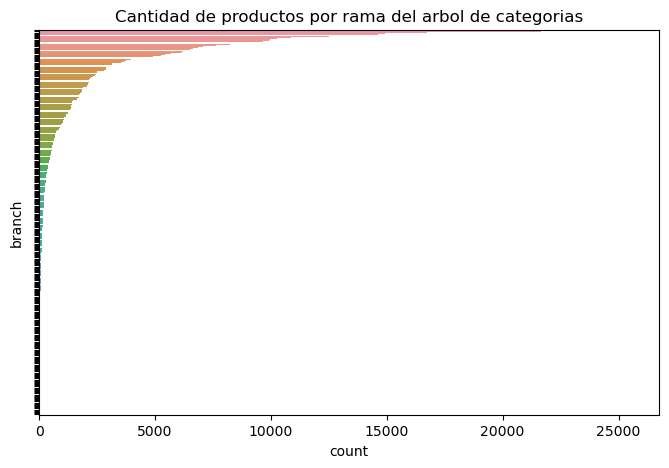

In [30]:
plot_branch_count(products_by_branch)

In [31]:
max_products = products_by_branch['count'].max()
min_products = products_by_branch['count'].min()

min_products, max_products

(1, 25484)

In [32]:
sampler = dt.Sampler(
    filtered_products,
    min_n_samples = MIN_PRODUCTS_BY_BRANCH,
    max_n_samples = MAX_PRODUCTS_BY_BRANCH,
    class_col     = 'branch'
)

In [33]:
sampled_products = sampler()
sampled_products.head()

Sampling...:   0%|          | 0/334 [00:00<?, ?it/s]

,id,family,category,sub_category,description,highlights,brand,gender,materials,branch,tokens_count,image_uri
221924,12407831,accessories,belts,n/d,Monogram Roller croc embossed belt,None,saint laurent,men,[Calf Leather],accessories~belts~n/d,5,12/40/78/31/12407831.jpg
221925,14461213,accessories,belts,n/d,woven belt,None,nicholas daley,men,"[Cotton, Jute]",accessories~belts~n/d,2,14/46/12/13/14461213.jpg
221926,14698816,accessories,belts,n/d,reversible Vintage Check belt,None,burberry,men,"[Thermoplastic Polyurethane (TPU), Leather, Co...",accessories~belts~n/d,4,14/69/88/16/14698816.jpg
221927,16201702,accessories,belts,n/d,4G Padlock belt,"[black, calf leather, signature 4G motif, padl...",givenchy,men,"[zamac, Calf Leather]",accessories~belts~n/d,3,16/20/17/02/16201702.jpg
221928,16618890,accessories,belts,n/d,Greca pattern print belt,"[black, gold-tone buckle fastening, engraved l...",versace,men,"[Leather, Fabric]",accessories~belts~n/d,4,16/61/88/90/16618890.jpg


In [34]:
filtered_products.shape, sampled_products.shape

((398670, 12), (98873, 12))

<Figure size 800x500 with 1 Axes>

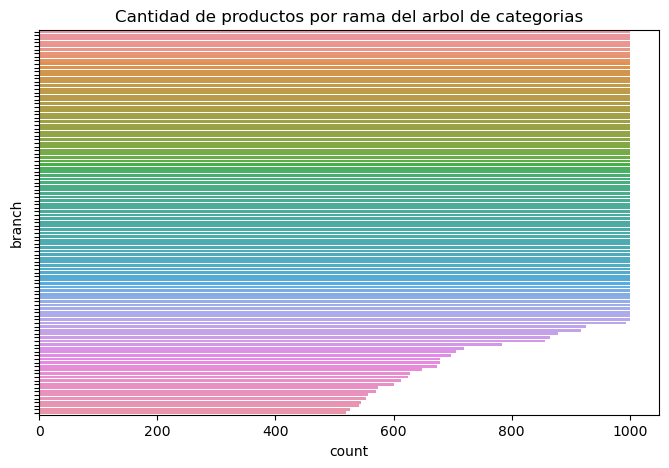

In [35]:
plot_branch_count(ut.group_by_count(sampled_products, 'branch', 'id'))

**Step 7**: Agregamos un número de secuencia que representa univocamente a cada branch:

In [36]:
sampled_products = dt.Sequencer('branch', 'branch_seq').perform(sampled_products)
sampled_products.head()

,id,family,category,sub_category,description,highlights,brand,gender,materials,branch,tokens_count,image_uri,branch_seq
0,12407831,accessories,belts,n/d,Monogram Roller croc embossed belt,None,saint laurent,men,[Calf Leather],accessories~belts~n/d,5,12/40/78/31/12407831.jpg,0
1,14461213,accessories,belts,n/d,woven belt,None,nicholas daley,men,"[Cotton, Jute]",accessories~belts~n/d,2,14/46/12/13/14461213.jpg,0
2,14698816,accessories,belts,n/d,reversible Vintage Check belt,None,burberry,men,"[Thermoplastic Polyurethane (TPU), Leather, Co...",accessories~belts~n/d,4,14/69/88/16/14698816.jpg,0
3,16201702,accessories,belts,n/d,4G Padlock belt,"[black, calf leather, signature 4G motif, padl...",givenchy,men,"[zamac, Calf Leather]",accessories~belts~n/d,3,16/20/17/02/16201702.jpg,0
4,16618890,accessories,belts,n/d,Greca pattern print belt,"[black, gold-tone buckle fastening, engraved l...",versace,men,"[Leather, Fabric]",accessories~belts~n/d,4,16/61/88/90/16618890.jpg,0


Cual es el numero total de categorias en el dataset luego de los pasos anteriores?

In [37]:
sampled_products['branch_seq'].max()

106

**Step 8**: Agregamos otros features a la descriptcon como genero highlight y materias para tratar de mejorar la predición.

<Figure size 640x480 with 1 Axes>

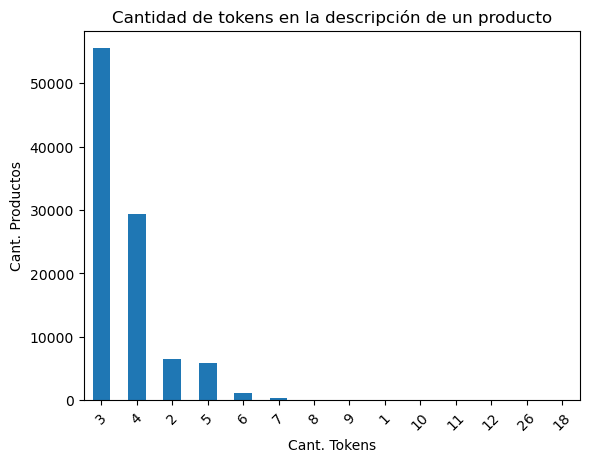

In [38]:
plot_tokens_count(sampled_products)

In [39]:
def preprocess_highlights(v):
    return '' if v is None else', '.join(v.replace('[', '').replace(']', '').strip(',').strip())

MAX_TAGS = 6

In [40]:
sampled_products = sampled_products[sampled_products['tokens_count'] < MAX_TOKENS]

	
highlights = sampled_products['highlights'].apply(lambda x: '. ' + preprocess_highlights(x)[:MAX_TAGS])

materials  = sampled_products['materials'].apply(lambda x: '. ' + ', '.join( ([] if x is None else x.tolist())[:MAX_TAGS]))

sampled_products['description']  = sampled_products['description'] + ' ' + sampled_products['gender']  + ' ' + sampled_products['brand'] + ' ' + materials + ' ' + highlights 

sampled_products['tokens_count'] = sampled_products['description'].apply(lambda x: len(x.split(' ')))


sampled_products.head()

,id,family,category,sub_category,description,highlights,brand,gender,materials,branch,tokens_count,image_uri,branch_seq
0,12407831,accessories,belts,n/d,Monogram Roller croc embossed belt men saint l...,None,saint laurent,men,[Calf Leather],accessories~belts~n/d,13,12/40/78/31/12407831.jpg,0
1,14461213,accessories,belts,n/d,"woven belt men nicholas daley . Cotton, Jute .",None,nicholas daley,men,"[Cotton, Jute]",accessories~belts~n/d,10,14/46/12/13/14461213.jpg,0
2,14698816,accessories,belts,n/d,reversible Vintage Check belt men burberry . T...,None,burberry,men,"[Thermoplastic Polyurethane (TPU), Leather, Co...",accessories~belts~n/d,15,14/69/88/16/14698816.jpg,0
3,16201702,accessories,belts,n/d,"4G Padlock belt men givenchy . zamac, Calf Lea...","[black, calf leather, signature 4G motif, padl...",givenchy,men,"[zamac, Calf Leather]",accessories~belts~n/d,13,16/20/17/02/16201702.jpg,0
4,16618890,accessories,belts,n/d,Greca pattern print belt men versace . Leather...,"[black, gold-tone buckle fastening, engraved l...",versace,men,"[Leather, Fabric]",accessories~belts~n/d,13,16/61/88/90/16618890.jpg,0


<Figure size 640x480 with 1 Axes>

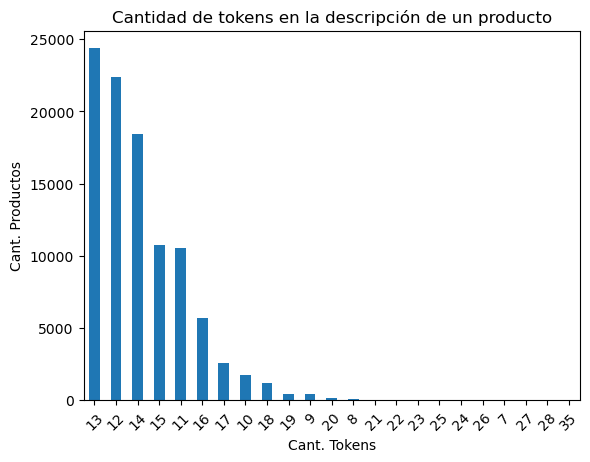

In [41]:
plot_tokens_count(sampled_products)

**Step 9**: Partimos el dataset en los conjuntos de entrenamiento, prueba y validación. Ademas se estratifica para minizar el efecto del desbalanceo de productos por branch.

In [42]:
train_set, test_set, _, _= train_test_split(
    sampled_products,
    sampled_products['branch_seq'].values,
    test_size     = 1 - TRAIN_SIZE,
    stratify      = sampled_products['branch_seq'].values,
    shuffle       = True
)

In [43]:
test_set, val_set, _, _= train_test_split(
    test_set,
    test_set['branch_seq'].values,
    test_size     = VAL_SIZE,
    shuffle       = False
)

**Step 10**: Chequeamos que en test y evaliacion existan las misma categorias que existe en train.

<Figure size 800x500 with 1 Axes>

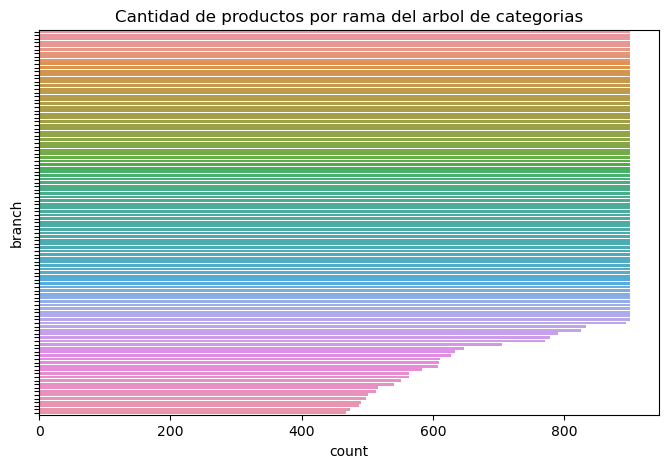

In [44]:
plot_branch_count(ut.group_by_count(train_set, 'branch', 'id'))

<Figure size 800x500 with 1 Axes>

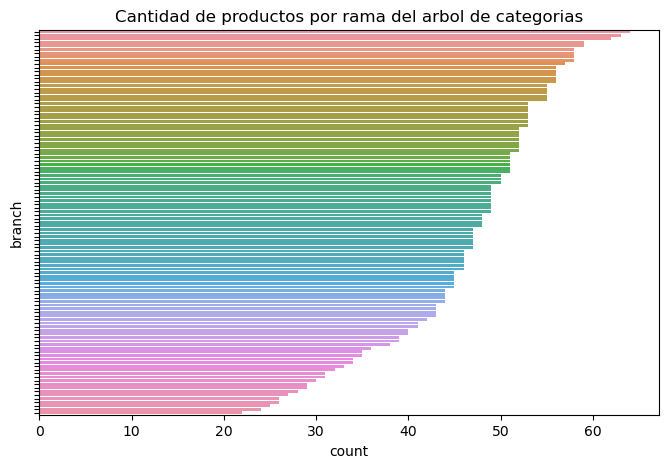

In [45]:
plot_branch_count(ut.group_by_count(val_set, 'branch', 'id'))

<Figure size 800x500 with 1 Axes>

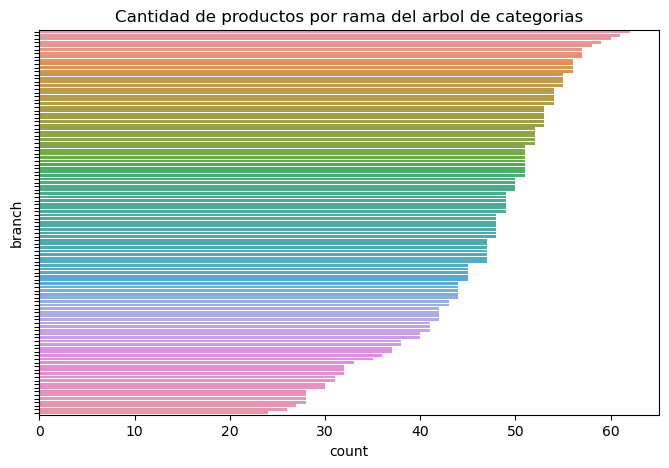

In [46]:
plot_branch_count(ut.group_by_count(test_set, 'branch', 'id'))

In [47]:
train_set.shape, val_set.shape, test_set.shape

((88985, 13), (4944, 13), (4944, 13))

**Step 11**: Los sets de validación y test deberian tener solo categorias que existan en el set de entrenamiento, de lo contrario, no es posible hacer la predicción.

In [48]:
val_set[val_set['branch_seq'].isin(train_set['branch_seq'].values)].shape

(4944, 13)

In [49]:
test_set[test_set['branch_seq'].isin(train_set['branch_seq'].values)].shape

(4944, 13)

**Step 12**: Guardamos todos los conjuntos preprocesados.

In [50]:
filtered_products.to_csv(f'{DATASET_PATH}/all.csv',   index=False)

In [51]:
train_set        .to_csv(f'{DATASET_PATH}/train.csv', index=False)
val_set          .to_csv(f'{DATASET_PATH}/val.csv',   index=False)
test_set         .to_csv(f'{DATASET_PATH}/test.csv',  index=False)